In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../data',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

100%|██████████| 170498071/170498071 [05:23<00:00, 526345.09it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [3]:
# behaves differently from MNIST / Fashion MNIST
# it is a Numpy array!
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [4]:
# we are working with color images now
train_dataset.data.shape

(50000, 32, 32, 3)

In [7]:
# behaves differently from MNIST / Fashion MNIST
# it is a list!
train_dataset.targets[0:15]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9]

In [8]:
# number of classes
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


In [9]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [10]:
# the data transformer mapped the data to (0, 1)
# and also moved the color channel before height/width
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(x.shape)
    break

tensor([[[[0.7020, 0.6941, 0.6941,  ..., 0.7765, 0.6235, 0.7176],
          [0.7137, 0.7059, 0.7098,  ..., 0.7922, 0.7608, 0.7843],
          [0.7294, 0.7255, 0.7255,  ..., 0.6863, 0.7137, 0.7216],
          ...,
          [0.5922, 0.5765, 0.5647,  ..., 0.3176, 0.3804, 0.4235],
          [0.5804, 0.5686, 0.5765,  ..., 0.3176, 0.3647, 0.4000],
          [0.5725, 0.5765, 0.5725,  ..., 0.3725, 0.3961, 0.4078]],

         [[0.7176, 0.7098, 0.7098,  ..., 0.8118, 0.6588, 0.7529],
          [0.7294, 0.7216, 0.7255,  ..., 0.8235, 0.7961, 0.8235],
          [0.7451, 0.7412, 0.7451,  ..., 0.7176, 0.7412, 0.7490],
          ...,
          [0.6118, 0.5961, 0.5843,  ..., 0.3373, 0.4000, 0.4314],
          [0.6000, 0.5882, 0.5961,  ..., 0.3373, 0.3843, 0.4157],
          [0.5922, 0.5961, 0.5922,  ..., 0.3922, 0.4157, 0.4275]],

         [[0.7137, 0.7059, 0.7059,  ..., 0.8392, 0.6902, 0.7843],
          [0.7255, 0.7176, 0.7176,  ..., 0.8471, 0.8275, 0.8549],
          [0.7412, 0.7294, 0.7294,  ..., 0

In [11]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        # define the conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

        # define the linear layers
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x

In [12]:
# Instantiate the model
model = CNN(K)

In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

In [16]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 1.7224,       Test Loss: 1.5056, Duration: 0:00:10.382968
Epoch 2/15, Train Loss: 1.4349,       Test Loss: 1.3755, Duration: 0:00:06.849839
Epoch 3/15, Train Loss: 1.3060,       Test Loss: 1.2666, Duration: 0:00:06.744362
Epoch 4/15, Train Loss: 1.2212,       Test Loss: 1.2244, Duration: 0:00:06.580808
Epoch 5/15, Train Loss: 1.1494,       Test Loss: 1.1715, Duration: 0:00:07.087536
Epoch 6/15, Train Loss: 1.0986,       Test Loss: 1.1763, Duration: 0:00:06.700383
Epoch 7/15, Train Loss: 1.0527,       Test Loss: 1.1229, Duration: 0:00:06.647774
Epoch 8/15, Train Loss: 1.0060,       Test Loss: 1.1037, Duration: 0:00:06.877374
Epoch 9/15, Train Loss: 0.9657,       Test Loss: 1.0723, Duration: 0:00:06.736744
Epoch 10/15, Train Loss: 0.9266,       Test Loss: 1.0938, Duration: 0:00:06.668797
Epoch 11/15, Train Loss: 0.8960,       Test Loss: 1.0473, Duration: 0:00:06.930235
Epoch 12/15, Train Loss: 0.8679,       Test Loss: 1.0422, Duration: 0:00:06.714595
Epoch 13/15, 

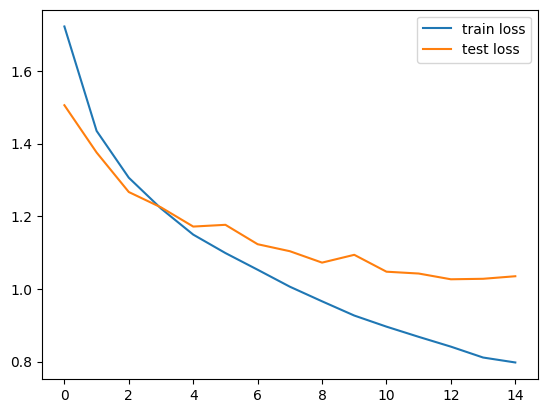

In [17]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [18]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # Move to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.7310, Test acc: 0.6475


In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[681  40  45  35  20   4   8  16 113  38]
 [ 29 775   6   9   3   3  13  10  60  92]
 [ 86  11 488 105 111  62  64  42  21  10]
 [ 28  10  73 539  69 148  52  47  20  14]
 [ 24   7  91  94 550  36  71  96  28   3]
 [ 13  11  49 263  61 495  21  67  10  10]
 [ 10  12  48 127  53  38 681  18  11   2]
 [ 27   5  36  64  54  66   9 715   6  18]
 [ 80  26  12  26   9   6   1   7 806  27]
 [ 55 135  12  28   6   7  14  23  50 670]]


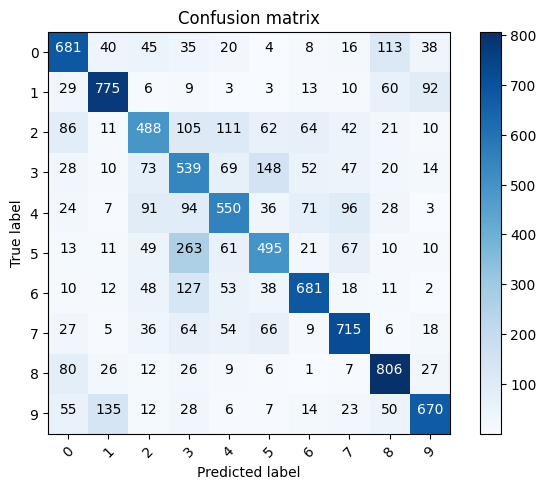

In [20]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    _, predictions = torch.max(outputs, 1)

    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [21]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

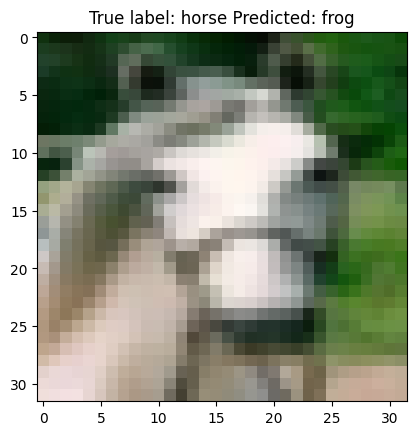

In [29]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));